In [1]:
from IPython.display import display,HTML
def dhtml(str):
    display(HTML("""<style>
    @import 'https://fonts.googleapis.com/css?family=Smokum&effect=3d';      
    </style><h1 class='font-effect-3d' 
    style='font-family:Smokum; color:#aa33ff; font-size:35px;'>
    %s</h1>"""%str))

In [2]:
dhtml('Code Library, Style, and Links')

In [3]:
import numpy as np,pandas as pd,keras as ks
import os,ast,cv2,warnings
import pylab as pl
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,\
classification_report
from keras.callbacks import ModelCheckpoint,\
ReduceLROnPlateau
from keras.models import Sequential
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Activation,Dropout,Dense,\
Conv2D,MaxPooling2D,GlobalMaxPooling2D
warnings.filterwarnings('ignore')
pl.style.use('seaborn-whitegrid')
style_dict={'background-color':'gainsboro','color':'#aa33ff', 
            'border-color':'white','font-family':'Roboto'}
fpath='../input/quickdraw-doodle-recognition/train_simplified/'
os.listdir("../input")

['quickdraw-doodle-recognition']

In [4]:
dhtml('Data Exploration')

In [5]:
I=64 # image size in pixels
S=17 # current number of the label set {1,...,17} -> {1-20,..., 321-340}
T=20 # number of labels in one set 
N=24000 # number of images with the same label in the training set
files=sorted(os.listdir(fpath))
labels=[el.replace(" ","_")[:-4] for el in files]
print(labels)

['The_Eiffel_Tower', 'The_Great_Wall_of_China', 'The_Mona_Lisa', 'airplane', 'alarm_clock', 'ambulance', 'angel', 'animal_migration', 'ant', 'anvil', 'apple', 'arm', 'asparagus', 'axe', 'backpack', 'banana', 'bandage', 'barn', 'baseball_bat', 'baseball', 'basket', 'basketball', 'bat', 'bathtub', 'beach', 'bear', 'beard', 'bed', 'bee', 'belt', 'bench', 'bicycle', 'binoculars', 'bird', 'birthday_cake', 'blackberry', 'blueberry', 'book', 'boomerang', 'bottlecap', 'bowtie', 'bracelet', 'brain', 'bread', 'bridge', 'broccoli', 'broom', 'bucket', 'bulldozer', 'bus', 'bush', 'butterfly', 'cactus', 'cake', 'calculator', 'calendar', 'camel', 'camera', 'camouflage', 'campfire', 'candle', 'cannon', 'canoe', 'car', 'carrot', 'castle', 'cat', 'ceiling_fan', 'cell_phone', 'cello', 'chair', 'chandelier', 'church', 'circle', 'clarinet', 'clock', 'cloud', 'coffee_cup', 'compass', 'computer', 'cookie', 'cooler', 'couch', 'cow', 'crab', 'crayon', 'crocodile', 'crown', 'cruise_ship', 'cup', 'diamond', 'dis

In [6]:
def display_drawing():
    for k in range(5) :  
        pl.figure(figsize=(10,2))
        pl.suptitle(files[(S-1)*T+k])
        for i in range(5):
            picture=ast.literal_eval(data[labels[(S-1)*T+k]].values[i])
            for x,y in picture:
                pl.subplot(1,5,i+1)
                pl.plot(x,y,'-o',markersize=1,color='slategray')
                pl.xticks([]); pl.yticks([])
            pl.gca().invert_yaxis(); pl.axis('equal');            
def get_image(data,lw=7,time_color=True):
    data=ast.literal_eval(data)
    image=np.zeros((300,300),np.uint8)
    for t,s in enumerate(data):
        for i in range(len(s[0])-1):
            color=255-min(t,10)*15 if time_color else 255
            _=cv2.line(image,(s[0][i]+15,s[1][i]+15),
                       (s[0][i+1]+15,s[1][i+1]+15),color,lw) 
    return cv2.resize(image,(I,I))

In [7]:
data=pd.DataFrame(index=range(N),
                  columns=labels[(S-1)*T:S*T])
for i in range((S-1)*T,S*T):
    data[labels[i]]=\
    pd.read_csv(fpath+files[i],
                index_col='key_id').drawing.values[:N]
data.head(3).T.style.set_properties(**style_dict)

,0,1,2
trombone,"[[[225, 218, 211, 197, 191, 185, 187, 194, 209, 226, 241, 251, 255, 252, 239, 219, 208], [6, 3, 5, 16, 26, 47, 70, 79, 86, 85, 74, 54, 19, 10, 1, 1, 5]], [[218, 144, 67, 18, 18, 21, 28, 194, 200], [5, 7, 18, 17, 42, 58, 72, 73, 69]], [[21, 12, 5, 0, 6, 20, 28, 29], [39, 35, 39, 52, 55, 53, 45, 39]], [[53, 71, 102, 232, 232, 159, 114, 95, 48, 41, 41, 47, 54], [75, 82, 86, 92, 124, 137, 138, 135, 119, 114, 94, 67, 58]], [[91, 96, 100, 99], [88, 90, 110, 138]]]","[[[35, 185, 209, 231, 237, 237, 222, 201, 137, 61, 4, 0, 1, 27, 67, 108, 255, 240, 234, 234, 237, 241, 251, 228, 178, 119, 74, 55], [153, 151, 148, 141, 127, 117, 108, 104, 98, 96, 83, 80, 76, 76, 65, 61, 59, 52, 36, 18, 12, 9, 8, 1, 0, 20, 27, 34]]]","[[[118, 113, 114, 120, 127, 134, 137, 141, 133, 127, 125], [6, 30, 50, 66, 73, 74, 69, 11, 0, 3, 10]], [[129, 136, 133], [27, 41, 29]], [[122, 104, 46, 36, 22], [7, 13, 18, 18, 13]], [[122, 96, 60, 40, 25], [72, 67, 51, 39, 20]], [[31, 31], [22, 22]], [[10, 27, 45, 88, 135, 217, 250, 249], [73, 85, 93, 105, 114, 113, 109, 106]], [[12, 13, 23, 54, 73, 131, 174, 255], [71, 66, 64, 83, 89, 94, 103, 111]], [[31, 23, 14, 5, 1, 0, 2, 10, 17, 23, 20], [76, 77, 73, 61, 48, 33, 25, 13, 11, 34, 67]]]"
truck,"[[[12, 0, 2, 18, 78, 81, 82, 62, 33, 10], [38, 67, 71, 76, 76, 67, 7, 0, 32, 36]], [[82, 97], [24, 28]], [[80, 95], [44, 49]], [[105, 94, 253, 255, 96], [4, 83, 82, 7, 7]], [[113, 111, 120, 129, 130, 120, 111], [85, 94, 99, 96, 86, 79, 80]], [[157, 154, 169, 174, 175, 171, 165, 165], [83, 94, 96, 93, 85, 80, 79, 82]], [[220, 210, 205, 223, 233, 231, 216], [79, 84, 94, 92, 88, 79, 76]]]","[[[68, 58, 47, 35, 31, 38, 45, 58, 66, 67, 60], [65, 61, 62, 73, 91, 99, 100, 94, 83, 72, 66]], [[170, 162, 150, 131, 123, 123, 126, 134, 147, 171, 173, 169, 160], [71, 68, 67, 72, 82, 92, 99, 103, 102, 87, 81, 72, 71]], [[19, 47, 146, 180, 183, 183, 179, 173, 161, 140, 83, 5, 0, 2, 15], [69, 71, 62, 66, 59, 32, 12, 2, 0, 3, 21, 27, 33, 42, 66]], [[181, 204, 244, 227, 215, 213, 216, 225], [65, 68, 65, 72, 85, 92, 103, 106]], [[237, 255, 248, 235], [101, 76, 66, 64]], [[230, 244], [107, 95]]]","[[[11, 67, 115, 224, 239, 244, 243, 231, 203, 189, 179, 170, 155, 78, 3, 0, 0, 21, 24], [41, 48, 5, 0, 27, 48, 70, 118, 162, 177, 183, 183, 175, 106, 103, 97, 85, 52, 39]], [[106, 200, 218, 221, 220, 201, 161, 115, 115], [38, 38, 40, 55, 75, 74, 56, 53, 35]], [[46, 45, 49, 72, 80, 78, 73, 60, 49, 46], [107, 125, 128, 129, 123, 111, 102, 97, 97, 100]], [[159, 154, 150, 150, 154, 164, 181, 199, 206, 207, 185, 151], [133, 133, 139, 152, 158, 164, 164, 157, 147, 133, 123, 128]], [[42, 133, 255], [107, 108, 99]]]"
trumpet,"[[[228, 165, 126, 97], [162, 138, 129, 109]], [[253, 244, 164, 113], [137, 137, 101, 91]], [[91, 86, 75, 51, 10], [97, 117, 128, 136, 142]], [[7, 40, 63, 79, 83, 77, 59, 44, 34, 21, 4, 0, 6], [134, 124, 105, 73, 41, 22, 3, 0, 5, 20, 56, 93, 105]], [[91, 96, 101], [22, 60, 73]], [[143, 134, 209], [106, 137, 176]], [[167, 164, 191, 255], [118, 145, 156, 193]]]","[[[1, 42, 189, 192, 172, 141, 128, 106, 98, 79, 68, 70, 133, 163], [22, 27, 27, 31, 53, 78, 86, 87, 86, 75, 62, 53, 29, 27]], [[175, 179], [27, 27]], [[191, 215, 239], [25, 26, 22]], [[187, 248, 255, 246, 224, 175], [21, 47, 0, 6, 6, 17]], [[175, 136, 107, 65, 0], [17, 19, 16, 22, 21]], [[91, 91], [13, 3]], [[81, 94], [3, 3]]]","[[[107, 213, 215, 229, 231, 243, 251, 255, 255, 252, 245, 230, 225], [69, 67, 105, 137, 151, 142, 119, 98, 61, 52, 45, 41, 84]], [[241, 243, 249, 247], [66, 116, 80, 63]], [[224, 166, 78, 78, 85, 145, 168, 238, 225, 221, 47, 0, 19, 24, 33, 50, 89, 135, 159], [99, 100, 106, 109, 128, 120, 122, 142, 148, 172, 152, 154, 76, 67, 63, 63, 72, 77, 76]], [[188, 166, 128, 127, 117, 101, 81, 63, 50, 40, 39, 25, 15], [123, 98, 34, 88, 111, 50, 7, 77, 29, 76, 53, 1, 22]]]"
umbrella,"[[[10, 19, 35, 58, 83, 110, 127, 149, 169, 193, 220, 238, 249, 255, 252, 244, 235, 207, 192, 186, 161, 137, 129, 103, 81, 70, 57, 37, 9, 3], [142, 120, 92, 71, 53, 39, 35, 35, 3

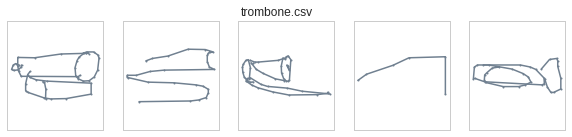

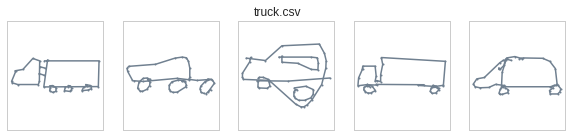

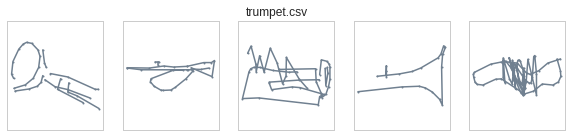

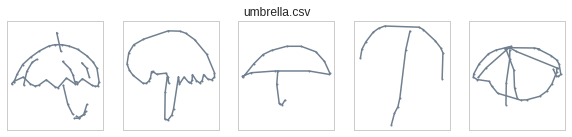

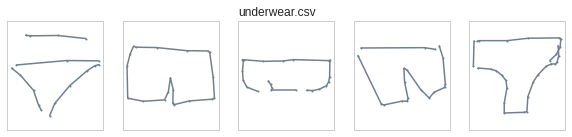

In [8]:
display_drawing()

In [9]:
images=[]
for label in labels[(S-1)*T:S*T]:
    images.extend([get_image(data[label].iloc[i]) 
                   for i in range(N)])
images=np.array(images,dtype=np.uint8)
targets=np.array([[]+N*[k] for k in range((S-1)*T,S*T)],
                 dtype=np.int32).reshape(N*T)
del data
images.shape,targets.shape

((480000, 64, 64), (480000,))

In [10]:
images=images.reshape(-1,I,I,1)
x_train,x_test,y_train,y_test=\
train_test_split(images,targets,
                 test_size=.2,random_state=1)
n=int(len(x_test)/2)
x_valid,y_valid=x_test[:n],y_test[:n]
x_test,y_test=x_test[n:],y_test[n:]
del images,targets
[x_train.shape,x_valid.shape,x_test.shape,
 y_train.shape,y_valid.shape,y_test.shape]

[(384000, 64, 64, 1),
 (48000, 64, 64, 1),
 (48000, 64, 64, 1),
 (384000,),
 (48000,),
 (48000,)]

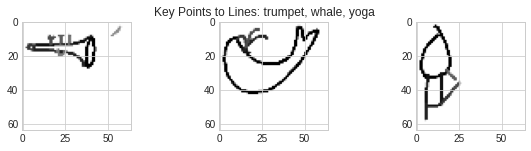

In [11]:
nn=np.random.randint(0,int(.8*T*N),3)
ll=labels[int(y_train[nn[0]])]+\
   ', '+labels[int(y_train[nn[1]])]+\
   ', '+labels[int(y_train[nn[2]])]
pl.figure(figsize=(10,2))
pl.subplot(1,3,1); pl.imshow(x_train[nn[0]].reshape(I,I))
pl.subplot(1,3,2); pl.imshow(x_train[nn[1]].reshape(I,I))
pl.subplot(1,3,3); pl.imshow(x_train[nn[2]].reshape(I,I))
pl.suptitle('Key Points to Lines: %s'%ll);

In [12]:
dhtml('The Model')

In [13]:
def model():
    model=Sequential()
    model.add(Conv2D(32,(5,5),padding='same',
                     input_shape=x_train.shape[1:]))
    model.add(LeakyReLU(alpha=.02))   
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(.2))
    model.add(Conv2D(196,(5,5)))
    model.add(LeakyReLU(alpha=.02))  
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(.2))
    model.add(GlobalMaxPooling2D())   
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=.02))
    model.add(Dropout(.5))   
    model.add(Dense(T))
    model.add(Activation('softmax'))
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',metrics=['accuracy'])
    return model
model=model()

In [14]:
print(set(y_train));
print(set(y_train-(S-1)*T))

{320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}


In [15]:
fw='weights.best.model.cv321-340.hdf5'
checkpointer=\
ModelCheckpoint(filepath=fw,verbose=2,
                save_best_only=True)
lr_reduction=\
ReduceLROnPlateau(monitor='val_loss',
                  patience=5,verbose=2,factor=.75)
history=model.fit(x_train,y_train-(S-1)*T,epochs=100,
                  batch_size=1024,verbose=2,
                  validation_data=(x_valid,y_valid-(S-1)*T),
                  callbacks=[checkpointer,lr_reduction])

Epoch 1/100

Epoch 00001: val_loss improved from inf to 0.89835, saving model to weights.best.model.cv321-340.hdf5
375/375 - 51s - loss: 2.2266 - accuracy: 0.4928 - val_loss: 0.8983 - val_accuracy: 0.7287 - lr: 0.0010
Epoch 2/100

Epoch 00002: val_loss improved from 0.89835 to 0.69389, saving model to weights.best.model.cv321-340.hdf5
375/375 - 50s - loss: 0.9401 - accuracy: 0.7076 - val_loss: 0.6939 - val_accuracy: 0.7872 - lr: 0.0010
Epoch 3/100

Epoch 00003: val_loss improved from 0.69389 to 0.63105, saving model to weights.best.model.cv321-340.hdf5
375/375 - 50s - loss: 0.7983 - accuracy: 0.7528 - val_loss: 0.6311 - val_accuracy: 0.8111 - lr: 0.0010
Epoch 4/100

Epoch 00004: val_loss improved from 0.63105 to 0.57414, saving model to weights.best.model.cv321-340.hdf5
375/375 - 50s - loss: 0.7177 - accuracy: 0.7767 - val_loss: 0.5741 - val_accuracy: 0.8259 - lr: 0.0010
Epoch 5/100

Epoch 00005: val_loss improved from 0.57414 to 0.53469, saving model to weights.best.model.cv321-340.hd

In [16]:
dhtml('Evaluation')

In [17]:
model.load_weights(fw)
model.evaluate(x_test,y_test-(S-1)*T)

1500/1500 [==============================] - 4s 3ms/step - loss: 0.3315 - accuracy: 0.8975


[0.33153143525123596, 0.8975416421890259]

In [18]:
p_test=model.predict(x_test)
p_test=[np.argmax(x) for x in p_test]
p_test[:10]

[0, 5, 5, 17, 15, 8, 6, 14, 11, 11]

In [19]:
well_predicted=[]
for p in range(len(x_test)):
    if (p_test[p]+(S-1)*T==y_test[p]):
        well_predicted.append(labels[(S-1)*T+p_test[p]])
u=np.unique(well_predicted,return_counts=True)
pd.DataFrame({'labels':u[0],'correct predictions':u[1]})\
.sort_values('correct predictions',ascending=False)\
.style.set_properties(**style_dict)

,labels,correct predictions
8,washing_machine,2368
19,zigzag,2339
3,umbrella,2336
13,windmill,2309
12,wheel,2281
9,watermelon,2256
14,wine_bottle,2255
18,zebra,2251
11,whale,2241
15,wine_glass,2236
